In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from datetime import datetime

import sys
sys.path.append('../lib/')
from blood_lib import import_pbc, learning_curves

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.metrics import classification_report_imbalanced, geometric_mean_score

2023-05-19 08:48:13.453239: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
tf.__version__

'2.12.0'

In [3]:
path = '../Data/PBC_6cat_masked/'

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    path,
    image_size=(128, 128),
    labels='inferred',
    interpolation='bicubic',
    label_mode='categorical',
    validation_split=0.20,
    batch_size=32,
    subset='both',
    shuffle=True,
    seed=1
)
class_names = train_ds.class_names
num_classes = len(class_names)
train_ds, test_ds = tf.keras.utils.split_dataset(train_ds, left_size=0.8, seed=1)
print('train batch :', tf.data.Dataset.cardinality(train_ds).numpy())
print('val batch :', tf.data.Dataset.cardinality(val_ds).numpy())
print('test batch :', tf.data.Dataset.cardinality(test_ds).numpy())
print('classes :', class_names)
print('num_classes :', num_classes)

Found 10868 files belonging to 6 classes.
Using 8695 files for training.
Using 2173 files for validation.


2023-05-19 08:50:50.125435: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [8695]
	 [[{{node Placeholder/_4}}]]
2023-05-19 08:50:50.125994: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [8695]
	 [[{{node Placeholder/_0}}]]


train batch : 218
val batch : 68
test batch : 55
classes : ['basophil', 'eosinophil', 'erythroblast', 'lymphocyte', 'monocyte', 'platelet']
num_classes : 6


Calcul des class_weights

On veut "accorder plus d'attention" aux exemples d'une classe sous-représentée

In [4]:
directory = Path(path)
class_weights = {}
total = len(list(directory.glob('**/*.png')))
for i, class_name in enumerate(class_names):
    #print(i, class_name)
    len_i = len(list(Path(directory/class_name).glob('*.png')))
    print(i, len_i)
    weight_for_i = (1 / len_i) * (total / num_classes)
    #print(weight_for_i)
    class_weights[i] = weight_for_i
class_weights

0 1218
1 3117
2 1551
3 1214
4 1420
5 2348


{0: 1.4871373836891078,
 1: 0.5811143193241364,
 2: 1.1678486997635933,
 3: 1.4920373421197144,
 4: 1.275586854460094,
 5: 0.7714366837024418}

Remarque : L'utilisation de class_weights modifie la plage de perte. Cela peut affecter la stabilité de l'entraînement en fonction de l'optimiseur. Les optimiseurs dont la taille de pas dépend de l'ampleur du gradient, comme tf.keras.optimizers.SGD , peuvent échouer. L'optimiseur utilisé ici, tf.keras.optimizers.Adam , n'est pas affecté par le changement d'échelle. Notez également qu'en raison de la pondération, les pertes totales ne sont pas comparables entre les deux modèles.

In [5]:
# Random data augmentation
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal_and_vertical", input_shape=(128, 128, 3)),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomBrightness(factor=0.001, value_range=(0,255)),
        tf.keras.layers.RandomContrast(factor=0.1)
    ])

def process_images(ds, shuffle=1000, augment=False):
    """
    Apply diverse images modification in a tf.data.Dataset
    """
    # rescale
    normalization_layer = tf.keras.layers.Rescaling(1./255)
    ds = ds.map(lambda x, y: (normalization_layer(x), y))
    # shuffle
    if shuffle != None:
        ds = ds.shuffle(shuffle)
    # augment
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y))
    return ds

train_ds = process_images(train_ds, shuffle=100, augment=True)
val_ds = process_images(val_ds, shuffle=None, augment=False)
test_ds = process_images(test_ds, shuffle=None, augment=False)

2023-05-19 08:50:56.385420: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_15' with dtype resource
	 [[{{node Placeholder/_15}}]]
2023-05-19 08:50:56.386186: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_17' with dtype resource
	 [[{{node Placeholder/_17}}]]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping

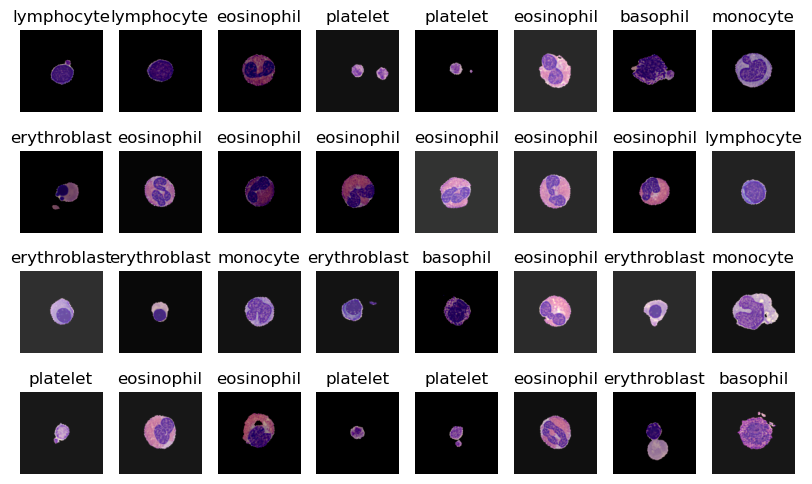

In [6]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10,6))
for i in range(32):
  ax = plt.subplot(4, 8, i + 1)
  plt.imshow(image_batch[i].numpy())
  plt.title(class_names[np.argmax(label_batch[i])])
  plt.axis("off")

In [7]:
import keras
from keras.layers import Dense, Flatten
from keras.optimizers import Adam
from keras.models import Model, Sequential
from keras import backend as K
from keras.applications.vgg19 import VGG19

# Modèle VGG16
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(128, 128, 3)) 

base_model.summary()

80134624/80134624 [==============================] - 39s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                             

In [8]:
# Freezer les couches du VGG16
for layer in base_model.layers[:-4]:
    layer.trainable = False
for layer in base_model.layers[-4:]:
    layer.trainable = True

model = Sequential()
model.add(base_model) # Ajout du modèle VGG16
model.add(Flatten()) 
model.add(Dense(2048,activation='relu'))
model.add(Dense(1028, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(num_classes, activation='softmax')) # model.add(Dense(11 +1, activation='softmax')) ??

model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.00001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 2048)              16779264  
                                                                 
 dense_1 (Dense)             (None, 1028)              2106372   
                                                                 
 dense_2 (Dense)             (None, 512)               526848    
                                                                 
 dense_3 (Dense)             (None, 6)                 3078      
                                                                 
Total params: 39,439,946
Trainable params: 26,494,986


In [9]:
epochs=50
log_dir = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
callbacks = [EarlyStopping(monitor='val_loss', patience=5),
             TensorBoard(log_dir=log_dir, histogram_freq=1)]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks,
    class_weight=class_weights
)

2023-05-19 08:54:28.414147: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_16' with dtype resource
	 [[{{node Placeholder/_16}}]]
2023-05-19 08:54:28.414646: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype resource
	 [[{{node Placeholder/_14}}]]


Epoch 1/50
218/218 [==============================] - ETA: 0s - loss: 0.5634 - accuracy: 0.8268

2023-05-19 09:02:10.516465: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2173]
	 [[{{node Placeholder/_4}}]]
2023-05-19 09:02:10.516787: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2173]
	 [[{{node Placeholder/_4}}]]


218/218 [==============================] - 561s 3s/step - loss: 0.5634 - accuracy: 0.8268 - val_loss: 0.2727 - val_accuracy: 0.9089
Epoch 2/50
218/218 [==============================] - 523s 2s/step - loss: 0.2297 - accuracy: 0.9293 - val_loss: 0.1746 - val_accuracy: 0.9439
Epoch 3/50
218/218 [==============================] - 518s 2s/step - loss: 0.1919 - accuracy: 0.9419 - val_loss: 0.1412 - val_accuracy: 0.9540
Epoch 4/50
218/218 [==============================] - 509s 2s/step - loss: 0.1768 - accuracy: 0.9447 - val_loss: 0.1485 - val_accuracy: 0.9526
Epoch 5/50
218/218 [==============================] - 507s 2s/step - loss: 0.1444 - accuracy: 0.9546 - val_loss: 0.1197 - val_accuracy: 0.9613
Epoch 6/50
218/218 [==============================] - 509s 2s/step - loss: 0.1368 - accuracy: 0.9574 - val_loss: 0.1151 - val_accuracy: 0.9636
Epoch 7/50
218/218 [==============================] - 507s 2s/step - loss: 0.1236 - accuracy: 0.9610 - val_loss: 0.0958 - val_accuracy: 0.9692
Epoch 8/50

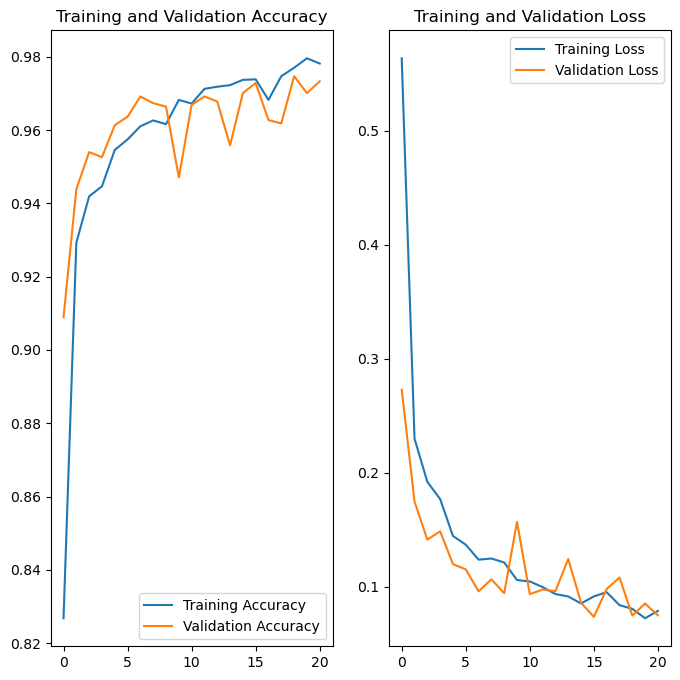

In [10]:
learning_curves(history)

In [12]:
model.save('../Models/VGG19_pt_6cat_4layers.h5')

In [13]:
VGG19 = tf.keras.models.load_model('../Models/VGG19_pt_6cat_4layers.h5')

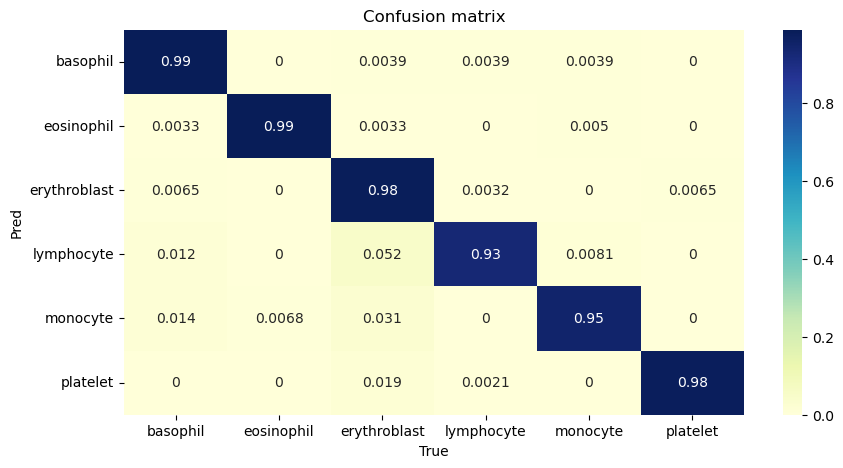

              precision    recall  f1-score   support

    basophil       0.96      0.99      0.97       256
  eosinophil       1.00      0.99      0.99       598
erythroblast       0.90      0.98      0.94       310
  lymphocyte       0.99      0.93      0.96       248
    monocyte       0.98      0.95      0.96       292
    platelet       1.00      0.98      0.99       469

    accuracy                           0.97      2173
   macro avg       0.97      0.97      0.97      2173
weighted avg       0.97      0.97      0.97      2173



In [14]:
preds = VGG19.predict(
        val_ds,
        batch_size=32,
        verbose=0
)
preds = np.argmax(preds, axis=1)
true = np.concatenate([y for x, y in val_ds], axis=0)
true = np.argmax(true, axis=1)
preds_labels = [class_names[preds[x]] for x in range(len(preds))]
true_labels = [class_names[true[x]] for x in range(len(true))]

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(true_labels, preds_labels, normalize='true')
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
plt.figure(figsize=(10, 5))
plt.title("Confusion matrix")
sns.heatmap(cm_df, annot=True, cmap="YlGnBu")
plt.ylabel("Pred")
plt.xlabel("True")
plt.show()
print(classification_report(true_labels,preds_labels))

2023-05-19 12:06:35.025078: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [1739,6]
	 [[{{node Placeholder/_1}}]]


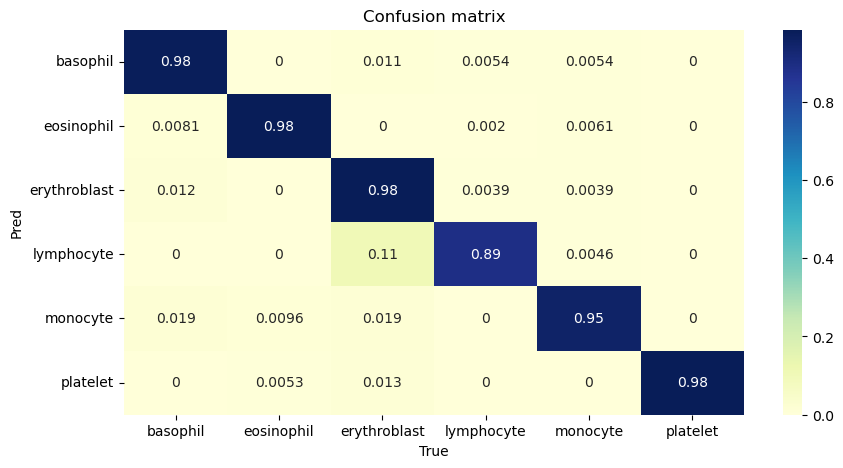

              precision    recall  f1-score   support

    basophil       0.94      0.98      0.96       186
  eosinophil       0.99      0.98      0.99       492
erythroblast       0.88      0.98      0.93       257
  lymphocyte       0.98      0.89      0.93       216
    monocyte       0.97      0.95      0.96       209
    platelet       1.00      0.98      0.99       379

    accuracy                           0.97      1739
   macro avg       0.96      0.96      0.96      1739
weighted avg       0.97      0.97      0.97      1739



In [16]:
preds = VGG19.predict(test_ds, batch_size=32, verbose=0)
preds = np.argmax(preds, axis=1)
true = np.concatenate([y for x, y in test_ds], axis=0)
true = np.argmax(true, axis=1)
preds_labels = [class_names[preds[x]] for x in range(len(preds))]
true_labels = [class_names[true[x]] for x in range(len(true))]

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(true_labels, preds_labels, normalize='true')
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
plt.figure(figsize=(10, 5))
plt.title("Confusion matrix")
sns.heatmap(cm_df, annot=True, cmap="YlGnBu")
plt.ylabel("Pred")
plt.xlabel("True")
plt.show()
print(classification_report(true_labels,preds_labels))